In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

# Part III: Linkage Based Clustering (Hierarchical Clustering)

In this section, we will explore a different method of clustering, hierarchical clustering. Unlike the K-means method that we have studied earlier, there are some limitations to the clustering algorithm. For example, choosing a pre-determined number of clusters beforehand, as well as the initial centroids (although the algorithm will always converge but might not be optimal if init points are arbitary). Additionally, K-means might also not perform well if the data is not sperical or if the data is sparse. 

Hierarchical clustering is an alternative approach to clustering that addresses some of the above issues. In this method, we do not need to specify the number of clusters beforehand. Instead, we build a hierarchy of clusters, also known as a dendrogram. We can then decide how many clusters we want by interpreting the dendrogram. At the end, we will then explore the use of a mixture of hierarchical clustering to find the initial centroids and K-means to optimize the clustering results. Additionally, we will also explore the use of dimensionality reduction techniques like PCA to reduce the dimensionality of the data and then perform clustering on the reduced data.

We will use the USArrests dataset which contains the statistics in arrests per 100000 residents for all 50 US states. The crime related features are Murder, Assault and Rape. UrbanPop represents the percentage of the population living in urban areas.

In [117]:
# Load in the dataset:
crimes = pd.read_csv('../datasets/USArrests.csv')

In [118]:
crimes.head(5)

,State,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6


Earlier, we recognised that the feature UrbanPop is a percentage of the population that were living in urban areas. Therefore, the 3 crime features are not on a similar measurement scale, therefore we might be required to scale the data later. However, we want to just use the raw data first.

**1. Hierarchical Clustering using Raw Data**

Using the raw data, we want to cluster the states using complete linkage and Euclidean distance, then cut the dendrogram at to give us 3 distinct clusters.

In [77]:
# Before applying the AgglomerativeClustering algorithm, we need to detach the state column from the dataset.

states = crimes.iloc[:,0]
crimes = crimes.drop('State', axis=1)

In [101]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

# Hierarchical clustering, complete linkage and euclidean distance:
model = AgglomerativeClustering(distance_threshold=120, n_clusters=None, affinity='euclidean', linkage='complete')
model.fit(crimes)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


AgglomerativeClustering(affinity='euclidean', distance_threshold=120,
                        linkage='complete', n_clusters=None)

In [102]:
states = np.array(states)

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

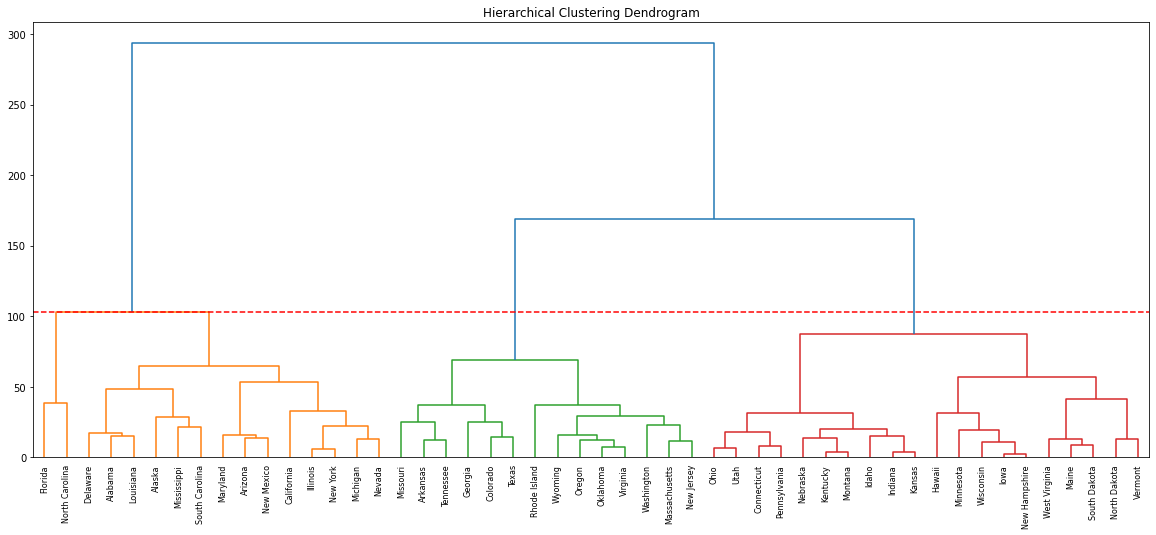

In [103]:
# Plot the dendrogram
plt.figure(figsize=(20, 8))
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model, labels=states, truncate_mode='level', color_threshold=105)
plt.hlines(105, 0, 500, colors='r', linestyles='dashed')

Looking at the dendrogram, we can see that that around the distance threshold range of around 105-175, the hierarchical clustering algorithm results in 3 clusters, as shown in the orange, green and red clusters. The first pairwise observations to be clustered together first based on nearest distance seem to be Iowa and New Hampshire, followed by Kentucky and Montana. The algiorithm continues to find the next nearest clusters and merge them together until we have 3 distinct clusters. The distance threshold where the clusters are 3 is 102.86. 

In [107]:
# Attach the cluster labels 
crimes['cluster'] = model.labels_
crimes['states'] = states

In [110]:
crimes.head(5)

,Murder,Assault,UrbanPop,Rape,cluster,states
0,13.2,236,58,21.2,0,Alabama
1,10.0,263,48,44.5,0,Alaska
2,8.1,294,80,31.0,0,Arizona
3,8.8,190,50,19.5,2,Arkansas
4,9.0,276,91,40.6,0,California


In [109]:
# cluster centroids based on each feature on cluster
crimes.groupby('cluster').mean()

,Murder,Assault,UrbanPop,Rape
cluster,,,,
0,11.812500,272.562500,68.312500,28.375000
1,4.270000,87.550000,59.750000,14.390000
2,8.214286,173.285714,70.642857,22.842857


If we look at the cluster centroids for the clusters on the features, we can see that states that are in cluster 0 have a high crime rate, while states in cluster 1 have a low crime rate. States in cluster 2 have a moderate crime rate. We can further visualise this using the pairplot between the features below and observe that our analysis is indeed true. However, we tell from the assault density kernels that there is very good seperation between the 3 clusters, which might lead us to believe that the clustering algortihm does very well on identifying the clusters based on the assault. The UrbanPop feature seems to have little influence on determining which clusters the states belong to.

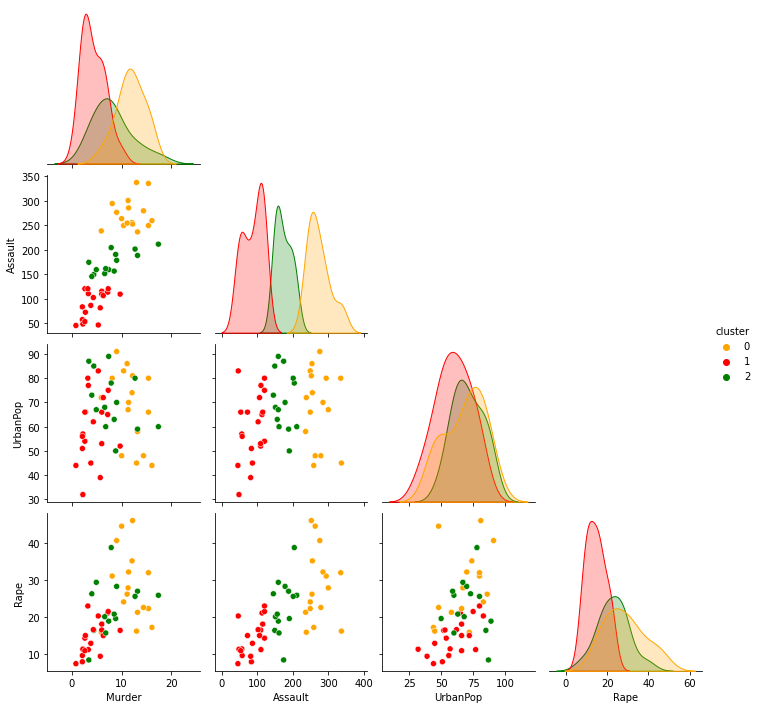

In [111]:
import seaborn as sns
sns.pairplot(crimes, hue='cluster', palette=['orange','red','green'], corner=True)

**2. Scaling the Data**

We specified earlier that because the crime features and UrbanPop are on different units of measurements, we might need to scale the data using StandardScaler. We then perform the same steps and then compare the results from earlier.

In [124]:
crimes = pd.read_csv('../datasets/USArrests.csv')
crimes = crimes.drop('State', axis=1)

In [125]:
# Scale data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
crimes_scaled = pd.DataFrame(scaler.fit_transform(crimes), columns=crimes.columns)

In [164]:
# Hierarchical clustering, complete linkage and euclidean distance:
model = AgglomerativeClustering(distance_threshold=4.46494857, n_clusters=None, affinity='euclidean', linkage='complete')
model.fit(crimes_scaled)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


AgglomerativeClustering(affinity='euclidean', distance_threshold=4.46494857,
                        linkage='complete', n_clusters=None)

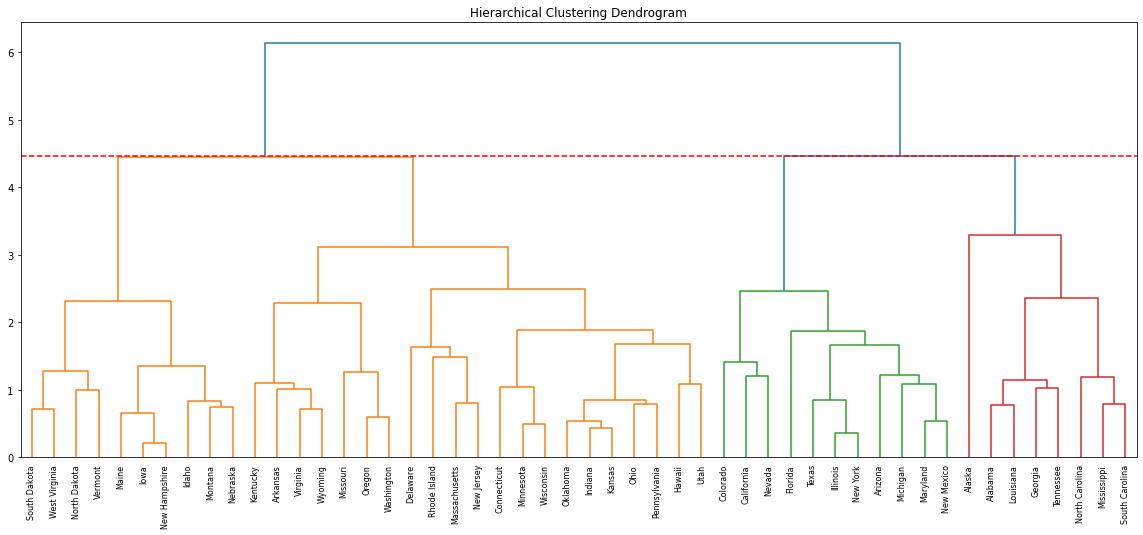

In [166]:
# Plot the dendrogram
plt.figure(figsize=(20, 8))
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model, labels=states, truncate_mode='level', color_threshold=model.distances_[-2])
plt.hlines(model.distances_[-2], 0, 500, colors='r', linestyles='dashed')


Upon scaling the data, we can observe that the dendrogram is quite different as compared to the previous one with the unscaled data. Prior to scaling the dataset, we observed that the feature assault had significantly higher values than the other features, which can impact the clustering algorithm because it uses a distance metric. By scaling the data, we ensure that all the features are on the same scale and therefore, the clustering algorithm will not be biased towards the feature with the higher values.

We also want to look at the each cluster centroids of all the features to understand what the characteristics of each cluster are.

In [168]:
# Cluster Centroids
crimes_scaled['cluster'] = model.labels_
crimes_scaled['states'] = states

crimes_scaled.groupby('cluster').mean()

,Murder,Assault,UrbanPop,Rape
cluster,,,,
0,-0.645859,-0.657892,-0.118728,-0.527735
1,1.461013,0.993817,-0.840237,0.356494
2,0.757594,1.131283,0.945679,1.227985


Now if we look at the cluster centroids, we can start to have an appreciation as to how the clusters are determined. There is more of a trend, especially in the case of cluster 2, where there is a higher percentage of UrbanPop, there is a higher level of assault and rape cases. For states with a lower UrbanPop, for cluster 1, it shows that the murder cases are high this those states. Cluster 0 shows states that have low crime rates. Therefore, we can perhaps start to understand that states that have a higher population percentage living in urban areas have higher crime rates of assault and rape, while states with a lower urban population tend to have quite high homocide rates.

Likewise, we want to plot a pairwise plot to cement our understanding.

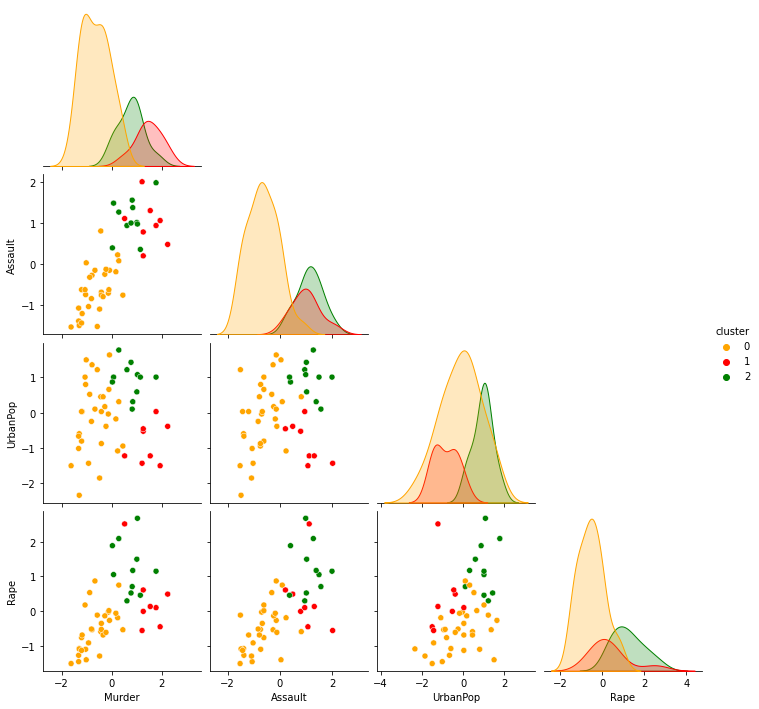

In [170]:
# Pairplot
sns.pairplot(crimes_scaled, hue='cluster', palette=['orange','red','green'], corner=True)

We observe that indeed states that are in cluster 0 have lower overall crime rates, as compared to the other 2 clusters. The decision to scale the data makes sense as this approach allows us to see the relationship between the Urbanpop variable and the crime featurs, so we choose to scale the data. If we look at the states in cluster 2, we can see that for those states, they are mainly the bigger and more populous states where they are more metropolitan areas like New York and California. Considering the recent events that have been occuring in the U.S, we can perhaps say that this clustering model does well in terms of identifying similar states, based on crime and urban population.

**3. PCA and Clustering**

In this section, we choose to do dimensionality reduction using PCA and then perform clustering on the reduced data. We will use the scaled data from the previous section. This will allow us to visualise the data in a 2D space to give us better understanding on how the clustering algorithm performs. We define the number of components to be 2, so that we can visualise the data in a 2D space. By choosing the number of components to be 2, we are able to explain about the 86.7% of the variance in the data, where the first PC explains 62% of the variance and the second PC explains 24.7% of the variance. 

In [173]:
# Take off the previous cluster column and state column
crimes_scaled = crimes_scaled.drop(['cluster', 'states'], axis=1)

In [235]:
# PCA on scaled data
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit_transform(crimes_scaled)
pca_scores = pd.DataFrame(pca.fit_transform(crimes_scaled), columns=['PC1', 'PC2'])
pca.explained_variance_ratio_

array([0.62006039, 0.24744129])

In [236]:
# Hierarchical clustering, complete linkage and euclidean distance on PC1 and PC2:
# model_PCA.distances_[-2] # get the distance threshold where it splits into 3 clusters, then apply back into the model
model_PCA = AgglomerativeClustering(distance_threshold=4.222683431452698, n_clusters=None, affinity='euclidean', linkage='complete')
model_PCA.fit(pca_scores)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


AgglomerativeClustering(affinity='euclidean',
                        distance_threshold=4.222683431452698,
                        linkage='complete', n_clusters=None)

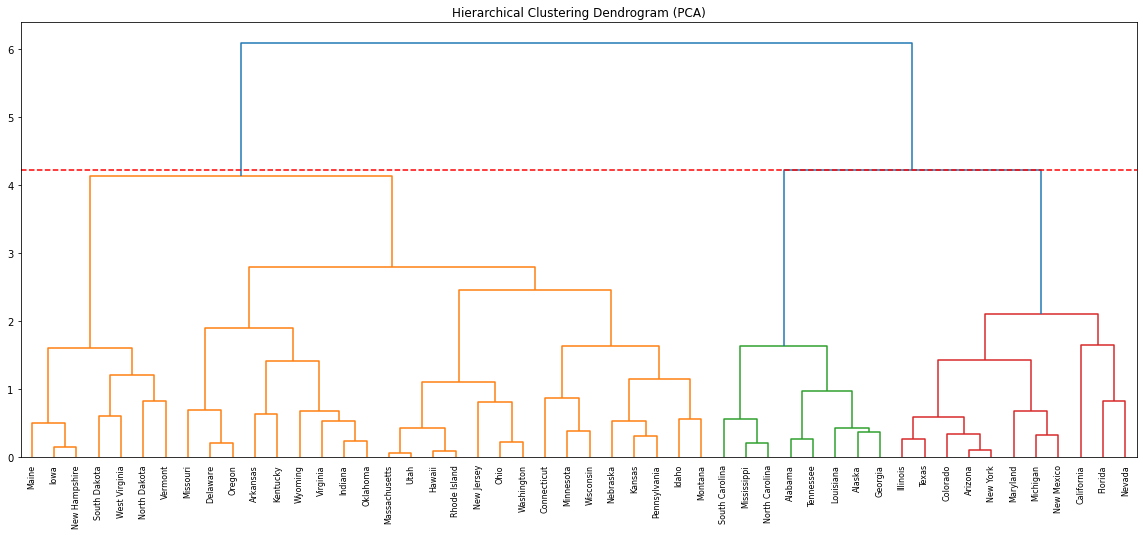

In [237]:
# Plot the dendrogram
plt.figure(figsize=(20, 8))
plt.title("Hierarchical Clustering Dendrogram (PCA)")
plot_dendrogram(model_PCA, labels=states, truncate_mode='level', color_threshold=model_PCA.distances_[-2])
plt.hlines(model_PCA.distances_[-2], 0, 500, colors='r', linestyles='dashed')

From the dendrogram, we can see that the hierarchical clustering algorithm results in 3 clusters, as shown in the orange, green and red clusters. The hierarchical clustering algorithm on the PCA scores of PC1 and PC2 are very similar to the hierarchical clustering done in Task 2. 

<Figure size 720x576 with 0 Axes>

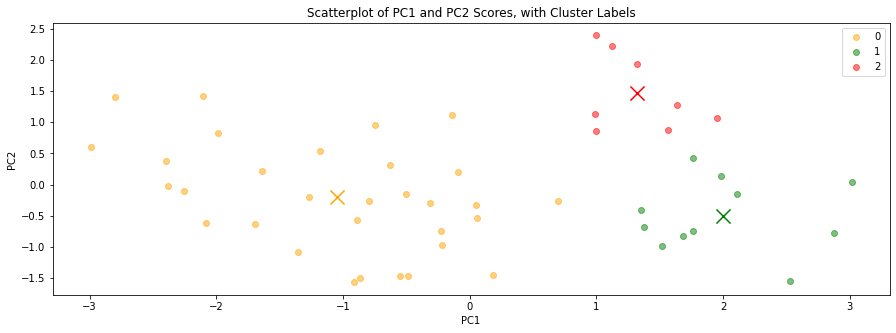

In [238]:
# Plot the scatterplot
pca_scores['cluster'] = model_PCA.labels_
pca_scores['states'] = states
plt.figure(figsize=(10, 8))
color_map = {0: 'orange', 1: 'green', 2:'red'}
plt.figure(figsize=(15, 5))

for type in [0,1,2]:
    is_cluster = pca_scores['cluster']  == type
    plt.scatter(pca_scores.loc[is_cluster, 'PC1'], pca_scores.loc[is_cluster, 'PC2'], 
                color=color_map[type], alpha=0.5, label=type)
    plt.scatter(pca_scores.loc[is_cluster, 'PC1'].mean(), pca_scores.loc[is_cluster, 'PC2'].mean(), marker='x', alpha=1, color=color_map[type], s=200)


plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Scatterplot of PC1 and PC2 Scores, with Cluster Labels')
plt.legend()  # Automatically uses labels specified in plt.scatter
plt.show()

In [240]:
# Get loadings of PC1 and PC2
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=crimes_scaled.columns)
loadings

,PC1,PC2
Murder,0.535899,0.418181
Assault,0.583184,0.187986
UrbanPop,0.278191,-0.872806
Rape,0.543432,-0.167319


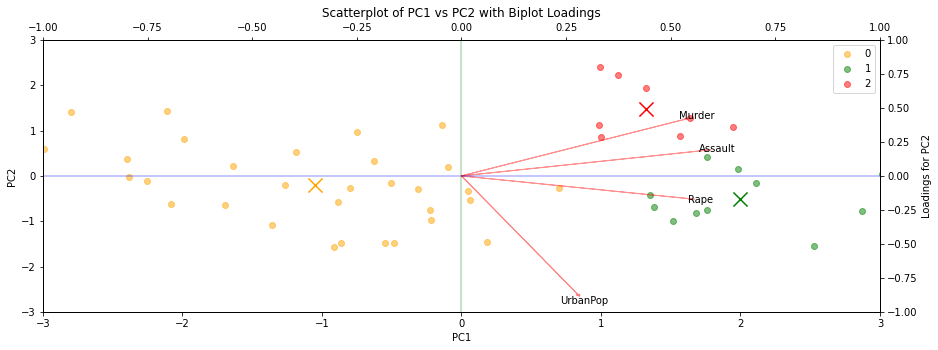

In [278]:
# Scatterplot of PC1 vs PC2 with biplot
fig, ax1 = plt.subplots(1,1)
twin_stacked = ax1.twiny().twinx()

for type in [0,1,2]:
    is_cluster = pca_scores['cluster']  == type
    ax1.scatter(pca_scores.loc[is_cluster, 'PC1'], pca_scores.loc[is_cluster, 'PC2'], 
                color=color_map[type], alpha=0.5, label=type)
    ax1.scatter(pca_scores.loc[is_cluster, 'PC1'].mean(), pca_scores.loc[is_cluster, 'PC2'].mean(), marker='x', alpha=1, color=color_map[type], s=200)
    
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=crimes_scaled.columns)
labels = loadings.index

# plot the biplot
for i in range(loadings.shape[0]):
    twin_stacked.arrow(0, 0, loadings.iloc[i, 0], loadings.iloc[i, 1], head_width=0.01, color='r', alpha=0.4)
    twin_stacked.text(loadings.iloc[i, 0]*1.05, loadings.iloc[i, 1]*1.05, labels[i], color='black', ha='center', va='center', fontsize=10)
# add x axes for loadings
twin_stacked.axhline(0, color='blue', alpha=0.3)
twin_stacked.axvline(0, color='green', alpha=0.3)

ax1.set_xlim(-3, 3)
ax1.set_ylim(-3, 3)
twin_stacked.set_xlim(-1, 1)
twin_stacked.set_ylim(-1, 1)
twin_stacked.figure.set_size_inches(15, 5)
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
twin_stacked.set_xlabel('Loadings for PC1')
twin_stacked.set_ylabel('Loadings for PC2')
ax1.set_title('Scatterplot of PC1 vs PC2 with Biplot Loadings')
ax1.legend()
plt.show()

From the plot above, we can see that similarly to the cluster centers in Task 2, we can see that states in cluster 0 have low crime rates. For cluster 1, we can see that rape cases tend to be higher in higher urban population states. For cluster 2, we can see that murder rates are the highest, where there is lower urban population. Comparing this to the group characteristics in Task 2, we can conclude that both the PCA and scaled hierarchical clustering yield similar results, group characteristics and interpretation.

**4. K-Means Clustering using Group Means**

In this section, we make use of the group means that we have found above in the hierarchical clustering that we have done on the PC scores, as the intital centroids for the K-means clustering. Seeing that we have 3 clusters, we will use K=3 as the number of predetermined clusters prior to running the algorithm. We then analyse the results to see how the K-means compares to the Hierarchical clustering algorithm.

In [284]:
# Get the cluster centroids
init_centroids = pca_scores.groupby('cluster').mean()
k_pca_scores = pca_scores.drop(['cluster', 'states'], axis=1)

In [286]:
from sklearn.cluster import KMeans

# K-Mean clustering on PC1 and PC2
kmeans = KMeans(n_clusters=3, init=init_centroids, n_init=1, random_state=5508)
kmeans.fit_predict(k_pca_scores)

array([2, 2, 1, 2, 1, 1, 0, 0, 1, 2, 0, 0, 1, 0, 0, 0, 0, 2, 0, 1, 0, 1,
       0, 2, 1, 0, 0, 1, 0, 0, 1, 1, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 1, 0,
       0, 0, 0, 0, 0, 0], dtype=int32)

In [287]:
# Attach the states and labels to the PC1 and PC2 scores
k_pca_scores['cluster'] = kmeans.labels_
k_pca_scores['states'] = states

In [302]:
# See which state is different in both clustering methods
pca_scores['kmeans_cluster'] = kmeans.labels_
diff = pca_scores[pca_scores['kmeans_cluster'] != pca_scores['cluster']]
diff

,PC1,PC2,cluster,states,kmeans_cluster
3,-0.141420,1.119797,0,Arkansas,2
24,0.696787,-0.263355,0,Missouri,1


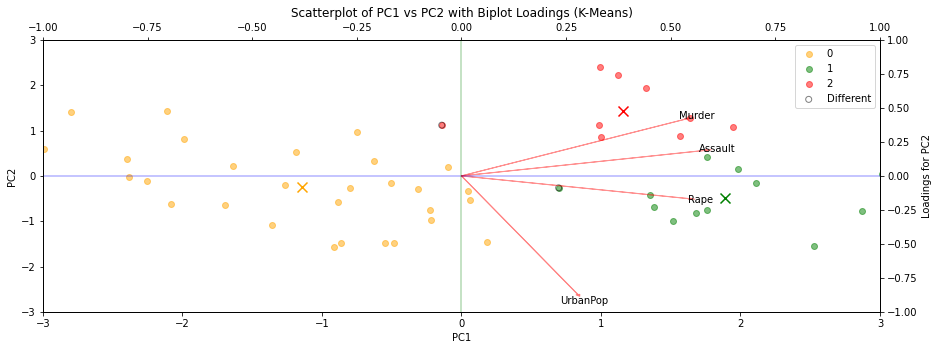

In [319]:
# Scatterplot of PC1 vs PC2 with biplot
fig, ax1 = plt.subplots(1,1)
twin_stacked = ax1.twiny().twinx()

for type in [0,1,2]:
    is_cluster = k_pca_scores['cluster']  == type
    ax1.scatter(k_pca_scores.loc[is_cluster, 'PC1'], k_pca_scores.loc[is_cluster, 'PC2'], 
                color=color_map[type], alpha=0.5, label=type)
    ax1.scatter(k_pca_scores.loc[is_cluster, 'PC1'].mean(), k_pca_scores.loc[is_cluster, 'PC2'].mean(), marker='x', alpha=1, color=color_map[type], s=100)
    
ax1.scatter(diff['PC1'], diff['PC2'], edgecolors='black', marker='o', alpha=0.5, color='none', label='Different')

loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=crimes_scaled.columns)
labels = loadings.index

# plot the biplot
for i in range(loadings.shape[0]):
    twin_stacked.arrow(0, 0, loadings.iloc[i, 0], loadings.iloc[i, 1], head_width=0.01, color='r', alpha=0.4)
    twin_stacked.text(loadings.iloc[i, 0]*1.05, loadings.iloc[i, 1]*1.05, labels[i], color='black', ha='center', va='center', fontsize=10)
# add x axes for loadings
twin_stacked.axhline(0, color='blue', alpha=0.3)
twin_stacked.axvline(0, color='green', alpha=0.3)

ax1.set_xlim(-3, 3)
ax1.set_ylim(-3, 3)
twin_stacked.set_xlim(-1, 1)
twin_stacked.set_ylim(-1, 1)
twin_stacked.figure.set_size_inches(15, 5)
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
twin_stacked.set_xlabel('Loadings for PC1')
twin_stacked.set_ylabel('Loadings for PC2')
ax1.set_title('Scatterplot of PC1 vs PC2 with Biplot Loadings (K-Means)')
ax1.legend()
plt.show()

If we compare the scatterplot from the K-means clustering to the plot using the Hierarchical Clustering method, we can see that the clustering is somewhat similar except for 2 instances. From the instances that we different, we can see that the state of Arkansas was clustered under cluster 2, and the state of Missouri in cluster 1 in the K-means clustering, where in the hierarchical clustering they were clustered under 0. 

By comparing the 2 scatterplots to determine which clustering algorithm produces a more accurate result, we perhaps conclude that the hierarchical clustering is slightly better, as the misclassified points visually look closer to cluster 0, than to their respective clusters in the K-means clustering.